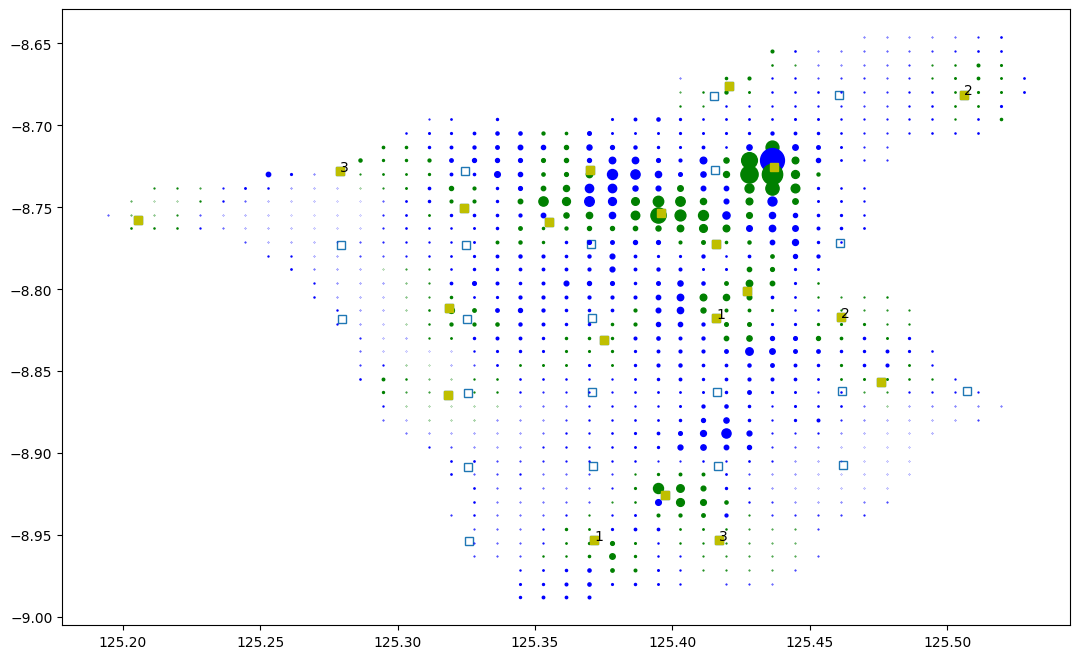

In [33]:
import pandas as pd
import numpy as np
from models.dynamic_models.single_step import single_step_area
from models.dynamic_models.visuializer import show_facility_location

#data constants
distances = pd.read_csv("data/ermera_full/processed/distances.csv").drop(columns=["Unnamed: 0"])
homes = pd.read_csv("data/ermera_full/processed/populations.csv").drop(columns=["Unnamed: 0"])
locations = pd.read_csv("data/ermera_full/processed/facilities.csv").drop(columns=["Unnamed: 0"])
periods_df = pd.DataFrame([1,2,3,4])
periods = periods_df[0]
per_period = 2
max_distance = 3
open_facilities = locations["is_built"]
vpop = homes["Population"]


Z, X, building = single_step_area(distances, homes, locations, periods, per_period, max_distance, open_facilities, vpop)

xC = homes['Pop_Lon']
yC = homes['Pop_Lat']
xF = locations['Grid_Lon']
yF = locations['Grid_Lat']

show_facility_location(xC, 
                       yC, 
                       xF, 
                       yF, 
                       X=X, 
                       Z=Z, 
                       homes=homes, 
                       locations=locations, 
                       periods=periods, 
                       vpop=vpop)

In [28]:
from utils.create_data import generate_facility_location_instance
service, customers, facilities = generate_facility_location_instance(100, 10000, 50)

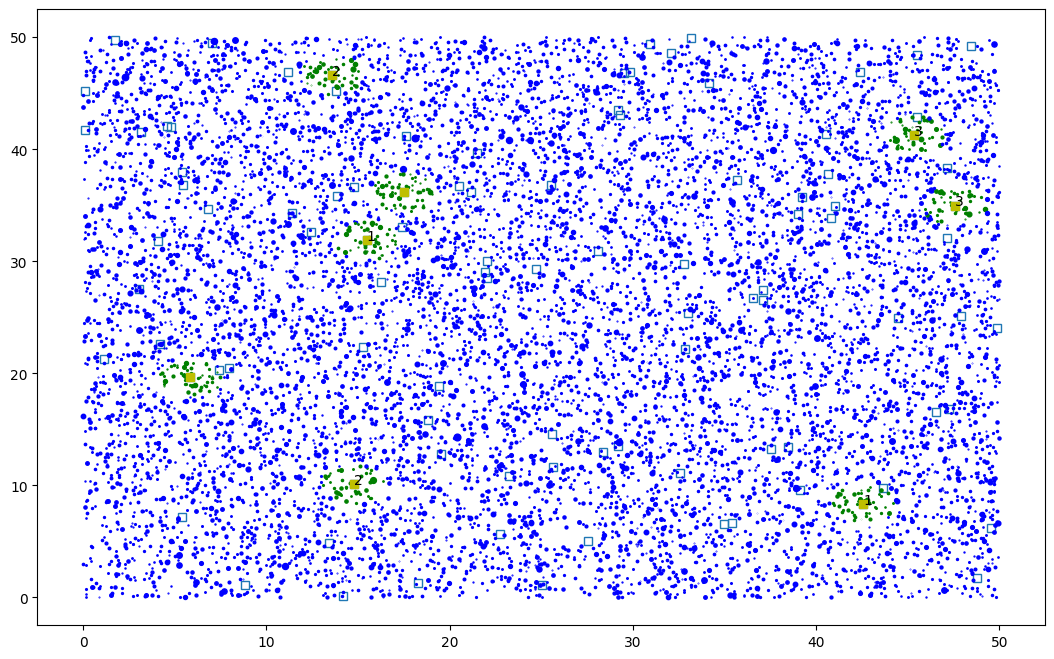

In [31]:
import pandas as pd
import numpy as np
from models.dynamic_models.single_step import single_step_area
from models.dynamic_models.visuializer import show_facility_location

#data constants
distances = service
homes = customers
locations = facilities
periods_df = pd.DataFrame([1,2,3,4])
periods = periods_df[0]
per_period = 2
max_distance = 3
open_facilities = facilities["is_built"]
vpop = customers["population"]

Z, X, building = single_step_area(distances, homes, locations, periods, per_period, max_distance, open_facilities, vpop)

xC = customers['Pop_Lon']
yC = customers['Pop_Lat']
xF = facilities['Grid_Lon']
yF = facilities['Grid_Lat']

show_facility_location(xC, 
                       yC, 
                       xF, 
                       yF, 
                       X=X, 
                       Z=Z, 
                       homes=homes, 
                       locations=locations, 
                       periods=periods, 
                       vpop=vpop)